In [0]:
import torch 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms 
from tqdm.notebook import  tqdm
from IPython.display import clear_output
from PIL import Image


In [0]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.5):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


transforms = transforms.Compose([
    
    transforms.Resize((64,64),interpolation=Image.NEAREST),
    torchvision.transforms.ToTensor(),
    AddGaussianNoise(mean = 0.1, std = 0.001),
])

train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transforms )

In [0]:
train_loader = torch.utils.data.DataLoader(train, batch_size = 16 ,shuffle = True)

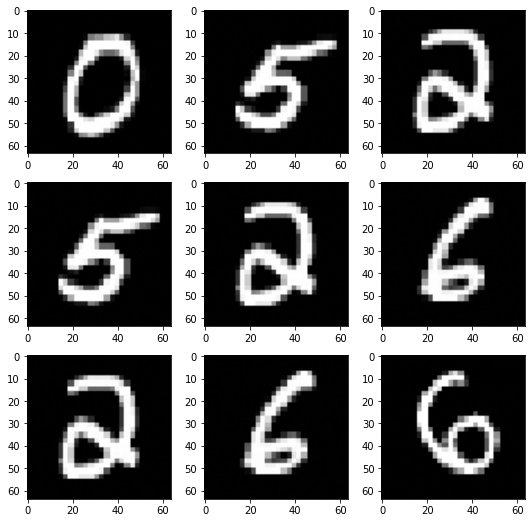

In [122]:
sample = next(iter(train_loader))
x, y = sample
x = x[:9]
fig, ax = plt.subplots(3,3, figsize = (9,9))
for m in range(3):
    for n in range(3):

        np_image = x[m+n].squeeze(0).detach().numpy()

        ax[m,n].imshow(np_image, cmap = "gray")

In [0]:

image_size = 32

# Number of channels
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 1

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

lr = 0.001

# Beta1 hyperparam for Adam optimizer
beta1 = 0.5

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [131]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


G = Generator()
G.apply(weights_init)
print(G)
G_optim = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [0]:
seed = torch.tensor([1.])
generated = G(seed.unsqueeze(0).unsqueeze(0).unsqueeze(0))
gen_np = generated.squeeze(0).squeeze(0).detach().numpy()

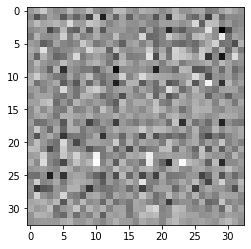

In [97]:
plt.imshow(gen_np, cmap = "gray")

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


D = Discriminator()
D.apply(weights_init)
D_optim = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))


In [108]:
D(generated)

tensor([[[[0.5429]]]], grad_fn=<SigmoidBackward>)

In [0]:
def plot_all_losses(d_real_loss, d_fake_loss, g_loss_run):
    plt.plot(d_real_loss, label = "D-real-loss")
    plt.plot(d_fake_loss, label = "D-fake-loss")
    plt.plot(g_loss_run, label = "G-loss")
    plt.legend()
    plt.show()

def show_gen_sample(z,G):

    seed = z[0].unsqueeze(0)
    samples = G(seed).detach().squeeze(0).squeeze(0)
    sample = samples.numpy()
    plt.imshow(sample, cmap = "gray")
    plt.show()


In [0]:
g_loss_run = []
d_real_loss_run = []
d_fake_loss_run = []

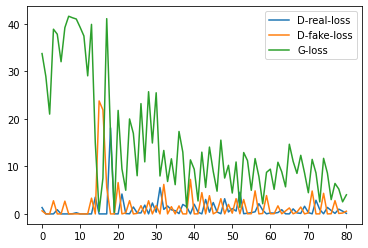

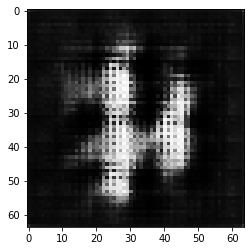

In [140]:

for epoch in range(2):    

    for data in tqdm(train_loader):

        print("epoch ", epoch +1 )
        x, label = data 

        nb_size = x.size(0)

        x = x.float()

        one_labels = torch.ones([nb_size, 1,1,1])
        zero_labels = torch.zeros([nb_size, 1,1,1])

        label = torch.as_tensor(label, dtype=torch.float)

        z = label.unsqueeze(1).unsqueeze(1).unsqueeze(1)
       
        G_sample = G(z)

        D_fake = D(G_sample)

        D_real = D(x)

        D_fake_loss = F.binary_cross_entropy(D_fake, zero_labels)
        D_real_loss = F.binary_cross_entropy(D_real, one_labels)

        D_loss = D_fake_loss + D_real_loss

        D_optim.zero_grad()
        D_loss.backward()
        D_optim.step()

        G_sample = G(z)
        D_fake = D(G_sample)

        G_loss =  F.binary_cross_entropy(D_fake, one_labels)

        G_optim.zero_grad()
        G_loss.backward()
        G_optim.step()

        g_loss_run.append(G_loss)
        d_real_loss_run.append(D_real_loss)
        d_fake_loss_run.append(D_fake_loss)

        clear_output(wait = True)

        plot_all_losses(d_real_loss_run, d_fake_loss_run, g_loss_run)

        show_gen_sample(z,G)



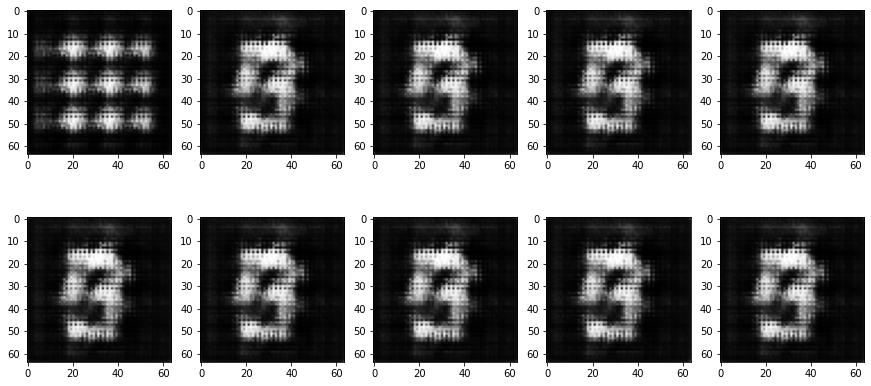

In [135]:
gen_images  = []

for i in range(0, 10):

    seed = torch.tensor([float(i)])
    generated = G(seed.unsqueeze(0).unsqueeze(0).unsqueeze(0))
    gen_np = generated.squeeze(0).squeeze(0).detach().numpy()

    gen_images.append(gen_np)

fig, ax = plt.subplots(2,5, figsize = (15,7))
for m in range(2):
    for n in range(5):

        np_image = gen_images[m+n]

        ax[m,n].imshow(np_image, cmap = "gray")   